# **Initialize**

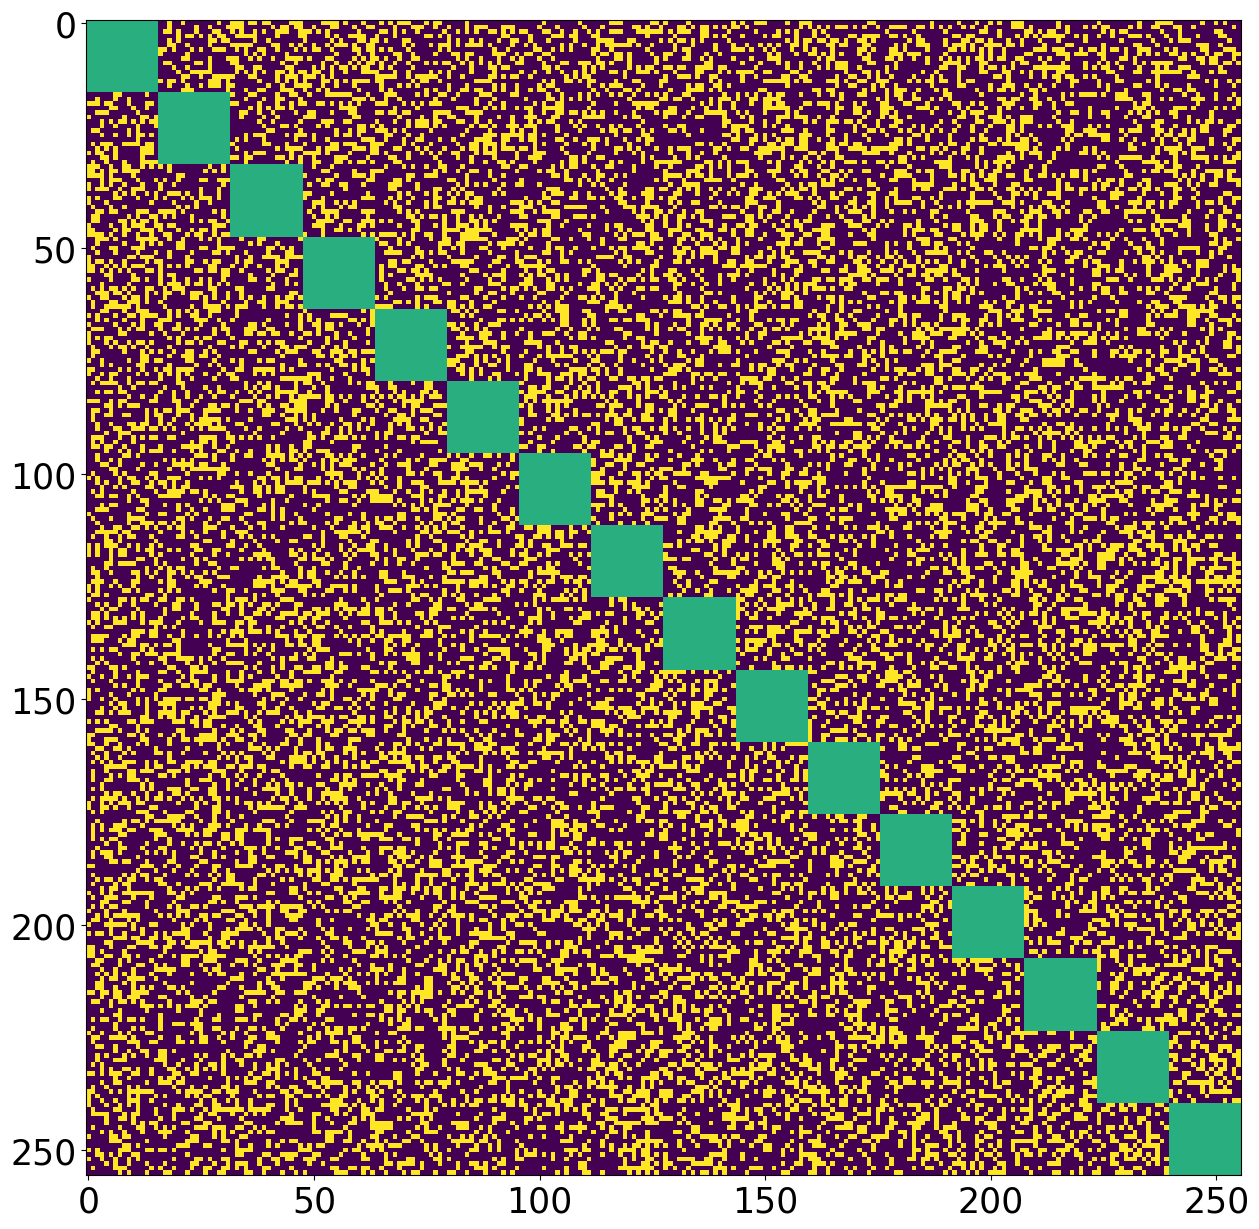

In [1]:
from numpy.ma.core import sqrt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy.random import *
import math
import random
from math import pi
import copy
import scipy

#Parameters
N = 16#8
m = 16#32
total = N*m
q = 1/3#1/8
a = 0.4#0.6
b = 0.8#0.4

"""
#Parameters
N = 8#8
m = 32#32
total = N*m
q = 1/8#1/8
a = 0.6#0.6
b = 0.4#0.4
"""

omega = 1
kappa = 64
dt = 0.05#0.05
time_step = 10**2 #5 * 10**6
t_max = (time_step - 1) * dt
gamma = 0.8

def prob_no_connection(q):
    prob = random.randint(1, 1/q)
    if prob != 1:
        return 0
    return b

# Initial Network
NW = np.array( [ [0.0] * total ] * total )
for i in range(total):
    for j in range(total):
        NW[i][j] = prob_no_connection(q) * b
        if int( i / m ) == int( j / m ) : NW[i][j] = a
for i in range(total):
    for j in range(i,total):
        NW[i][j] = NW[j][i]

#整形
plt.figure(figsize=[15,15])
plt.rcParams["font.size"] = 25

plt.imshow(NW)
# Initial phi's uniform distribution　（初期値θは一様分布）
theta = np.random.random_sample(total)*2*pi 
# Initial phi's uniform distribution　（初期値dθは標準正規分布）
dtheta= [0]*(total)
for i in range(total):
    dtheta[i] = random.normalvariate(0,1)

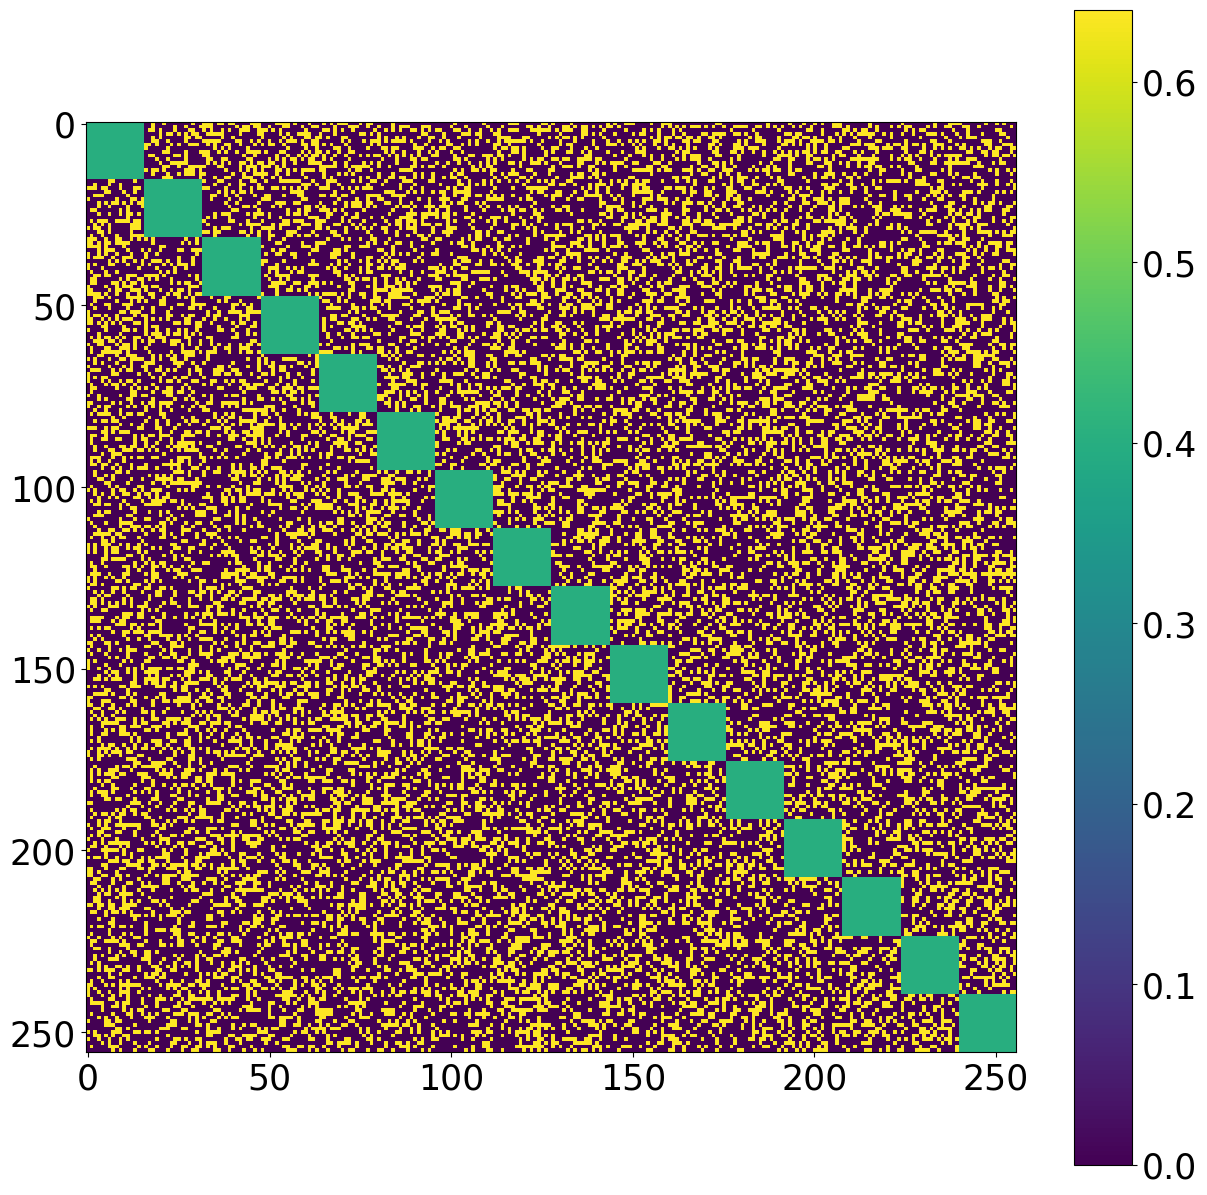

In [2]:
fig, ax = plt.subplots(figsize=[15,15])
plt.rcParams["font.size"] = 25
aximg = ax.imshow(NW)

fig.colorbar(aximg, ax=ax)
plt.show()

There is a way to find feature of Chaotic trajectory

https://aip.scitation.org/doi/pdf/10.1063/5.0063384

$$
\dot{\theta_i} = \omega + \frac{1}{\kappa} \sum^{}_{j=1} K(i,j) sin(\theta_j - \theta_i - \alpha)
$$

$$
K_{ij} = 
    \begin{cases}
        {a \ \ \ \ \rm{if \ i \ and\ j\ are\ in\ the\ same\ community\ or}}\\
        {b \ \ \ \  \rm{otherwise}}
\end{cases}
$$


> We simulated a network composed of N = 8 communities of
m = 32 oscillators each. The probability of connections across communities was set to q = 1/8, with connection strengths of a = 0.6
within communities and b = 0.4 across. The natural frequency used
was ω = 1 and the normalization constant κ = 64. We ran 1500
simulations with values of β distributed uniformly at random in the
range [0, 2π ) using a **4th-order Runge–Kutta algorithm**, using a step
size of 0.05 for numerical integration. Each simulation was run for
5 × 106
time steps, discarding the first 104
to avoid transient effects
and applying a thinning factor of 5. For the results presented here,
we used γ = 0.8, and we confirmed that results were qualitatively
stable for a wide range of threshold values. All information-theoretic
measures are reported in bits.

# **Make Cluster**

$$
\boldsymbol{\phi} = \boldsymbol{\omega} + \boldsymbol{A} * sin(
$$

$$
\boldsymbol{A} \boldsymbol{v} = \boldsymbol{A} \lambda
$$

**スペクトラルクラスタリング**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


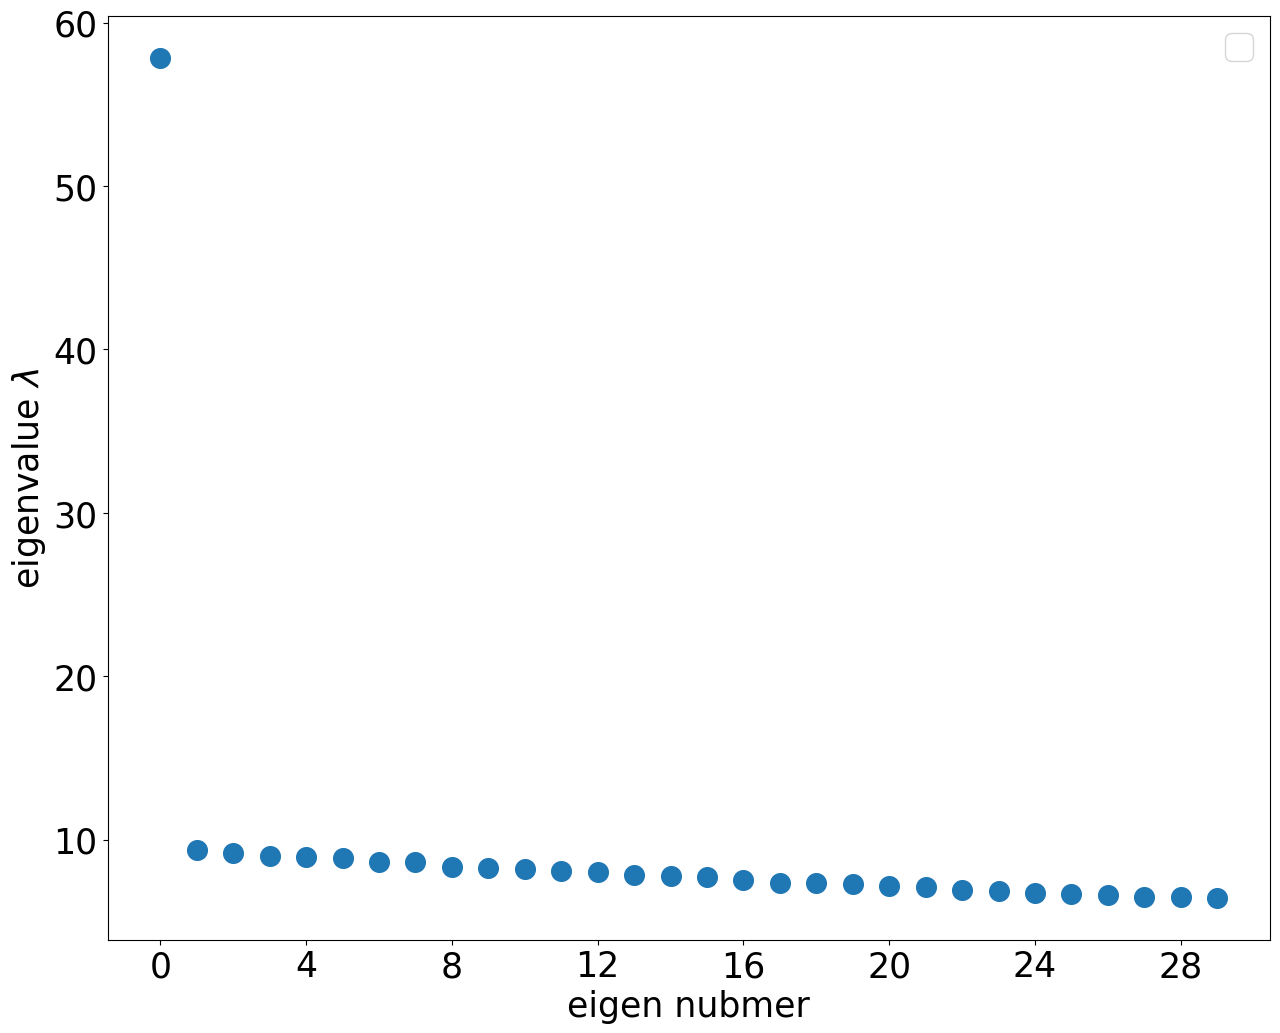

In [3]:
from numpy.lib.shape_base import vsplit
from matplotlib import ticker 
import numpy.linalg as LA
import scipy.linalg

lamb,vecs = LA.eig(NW)
lamb = np.sort(lamb)[::-1]
P = vecs[np.argsort(lamb)[::-1]]

x = [i for i in range(total)]
#整形
plt.figure(figsize=[15,12])
plt.rcParams["font.size"] = 25

plt.scatter(x[:30],lamb[:30],s=200)
#plt.scatter(x,lamb)
#plt.yscale("log")
#plt.title( "relation of Wolfram class num")
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel('eigen nubmer')
plt.ylabel('eigenvalue '+r'$\lambda$')
plt.legend()

# **Nの決定**

In [4]:
from statistics import stdev, variance, median

big_lamb = []
for i in range(total):
    if lamb[i] > np.sqrt(2)*stdev(lamb):
        big_lamb.append(lamb[i])
N = len(big_lamb)
print(N)

N = 4

8


# **どのクラスターに帰属するか**

In [5]:
import pandas as pd
import numpy as np
from scipy import linalg
from sklearn.cluster import SpectralClustering
#相関行列の読み込み
cor = NW

#隣接行列
A=NW# cor-np.diag([1 for _ in range(len(cor))])

#対角行列
D= np.diag(A.sum(axis=1))

#ラプラシアン行列
L = D-A

#正規化ラプラシアン行列
L_norm=((np.linalg.inv(D)**(1/2))) @ L @ ((np.linalg.inv(D)**(1/2)))

#固有値分解(昇順で結果が出る)
vals, vecs = linalg.eig(L_norm) 

#SpectralClustering
sc = SpectralClustering(N, affinity='precomputed', n_init=100,assign_labels='kmeans',random_state=0)
clusters = sc.fit(A) 

cluster_nums = clusters.labels_

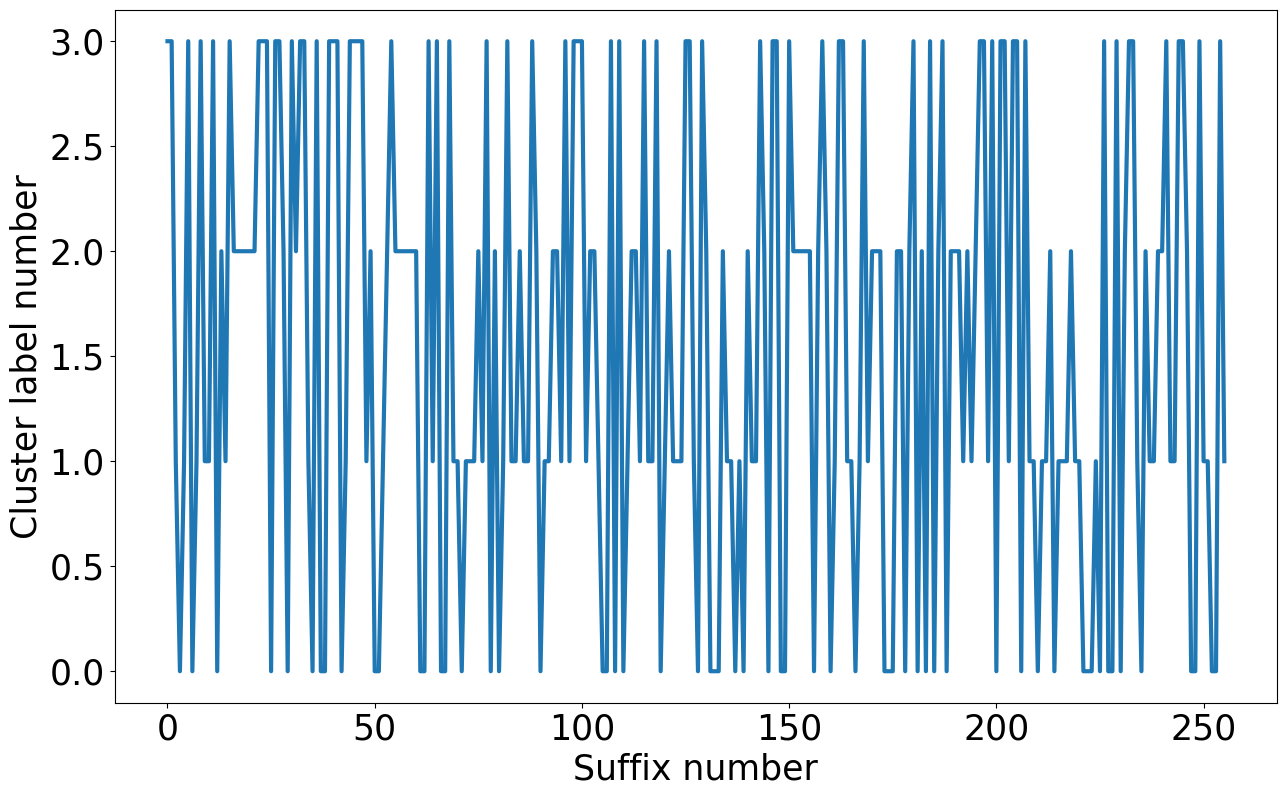

In [6]:
plt.figure(figsize=(15,9))
plt.ylabel('Cluster label number')
plt.xlabel('Suffix number')
plt.plot(x,cluster_nums, lw=3)

In [7]:
def K( i , j ):
    i_gr = int( i / N )
    j_gr = int( j / N )
    res = a
    if i_gr != j_gr :
        res = b
    return res 

def fun(i,theta,alpha):
    thetadot = omega
    for j in range(total):
        #thetadot += K( i , j ) * np.sin( theta[ j ] - theta[ i ] - alpha ) * NW[i][j]
        thetadot += np.sin( theta[ j ] - theta[ i ] - alpha ) * NW[i][j]
    return thetadot

In [8]:
def calc_coupl(x,x_b,alpha):
    for i in range(total):
        x[i] = fun(i,x_b,alpha)

def RungeKutta(alpha):
    t = 0.0
    dtheta_hist = []
    theta_hist = []
    t_hist = []

    x = np.random.random_sample(total)*(2*pi) 
    x_b = np.empty(total)
    x_temp = np.empty(total)
    x_b1 = np.empty(total)
    x_b2 = np.empty(total)
    x_b3 = np.empty(total)
    x_b4 = np.empty(total)

    for i in range(total):
        x_b[i] = x[i]

    step = 0
    while step < time_step : 
        step += 1
        #if step%10 == 0 : print(t)
        for i in range(total):
            x_b[i]=x[i]
        
        calc_coupl(x_b1,x_b,alpha)

        for i in range(total):
            x_temp[i] = x_b1[i] * 0.5*dt + x_b[i]
            
        calc_coupl(x_b2,x_temp,alpha)
            
        for i in range(total):
            x_temp[i]=x_b2[i] * 0.5*dt + x_b[i]
                
        calc_coupl(x_b3,x_temp,alpha)
                
        for i in range(total):
            x_temp[i] = x_b3[i]*dt + x_b[i]
        
        calc_coupl(x_b4,x_temp,alpha)
        
        for i in range(total):
            x[i] = x_b[i] + (x_b1[i]+2*x_b2[i]+2*x_b3[i]+x_b4[i])*dt/6.0
            x[i] = x[i] % (2.0*pi)
        
        #print(x)
        tmp = copy.copy(x)
        dtheta_hist.append(tmp)
        tmp = copy.copy(x_b)
        theta_hist.append(tmp)
        t_hist.append(t)

        t+=dt

    return np.array(dtheta_hist), np.array(theta_hist), np.array(t_hist)

In [9]:
def Euler(theta,dtheta,alpha):
    theta_hist = []
    dtheta_hist = []
    t_hist = []

    t = 0.0 ; step = 0
    while step < time_step : 
        t += dt ; step += 1
        dtheta = [0 for _ in range(total)]
        for i in range(total):
            dtheta[i] = fun(i,theta,alpha)
            theta[i] += dtheta[i]*dt
            theta[i] = theta[i] % (2*pi)
        
        #記録
        tmp = copy.copy(dtheta)
        dtheta_hist.append(tmp)

        tmp = copy.copy(theta)
        theta_hist.append(tmp)

        t_hist.append(t)

    return dtheta_hist,theta_hist,t_hist

# **RUN SIMULATION**

In [10]:
beta = 0.2
dt = 0.05#0.05
time_step = 10**1 #5 * 10**6
t_max = (time_step - 1) * dt

#dtheta_hist,theta_hist,t_hist = Euler(theta,dtheta,pi/2 - beta)
dtheta_hist,theta_hist,t_hist = RungeKutta(pi/2 - beta)

cut  the first few seconds to avoid transient effects and applying a thinning factor of 5.

In [11]:
cuting_frame = 2#50
theta_hist = theta_hist[cuting_frame:]
t_hist = t_hist[cuting_frame:]

Text(0, 0.5, '$\\theta_2$')

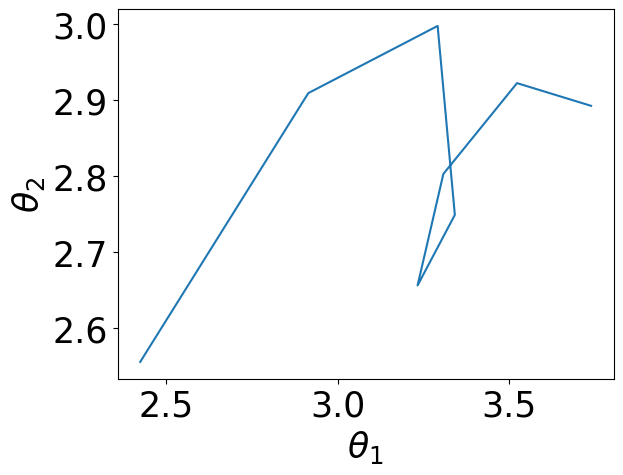

In [12]:
tmp_dtheta_hist = np.array(dtheta_hist)
tmp_theta_hist = np.array(theta_hist)
tmp_t_hist = np.array(t_hist)
plt.plot(tmp_theta_hist[:,2], tmp_theta_hist[:,50])
#plt.plot(tmp_t_hist,tmp_theta_hist[:,3])
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')

$$
R_c(t) = | <e^{i \theta_j(t)}>_{j \in I_c} |
$$

$$
X_t^c = \begin{cases}
        {1 \ \  R_c(t) > \gamma }\\
        {0 \ \ otherwise}
    \end{cases}
$$

In [13]:
import cmath 
import collections

def indexfunc(lst, value):
    return [i for i, x in enumerate(lst) if x == value]

def calc_R(theta_hist):
    R = np.array( [ [0.0] * N] * len(theta_hist) )
    for k in range(len(theta_hist)):
        for c in range(N):
            sum = 0.0
            member = indexfunc(cluster_nums,c)
            for id in member:
                sum += cmath.exp( theta_hist[k][id] * 1j ) 
            R[k][c] = abs( sum ) / len(member)
    return R

def calc_X(R):
    X = np.array( [ [0] * N] * len(theta_hist) )
    for k in range(len(theta_hist)):
        for c in range(N):
            if R[k][c] > gamma :
                X[k][c] = 1
            else :
                X[k][c] = 0
    return X

def weight(R):
    weight_list = []
    for i in range(max(cluster_nums)+1):
        weight_list.append(len([j for j in cluster_nums if j == i]))
    return np.array(weight_list)

def calc_lambda(R):
    weight_array = weight(R)
    lambda_c = []
    for c in range(N):
        lambda_c.append(variance(R[:,c]))
    return np.average(lambda_c,weights=weight_array)

def calc_Xi(R):
    weight_array = weight(R)
    Xi = np.average(R,axis = 1,weights=weight_array)
    return np.average(Xi)

In [14]:
R = calc_R(theta_hist)
X = calc_X(R)
Xi = calc_Xi(R)
lamb = calc_lambda(R)
print(Xi)
print(lamb)

0.1371279457758811
0.005094975621830223


Text(0.5, 1.0, 'Rc with beta = 0.2')

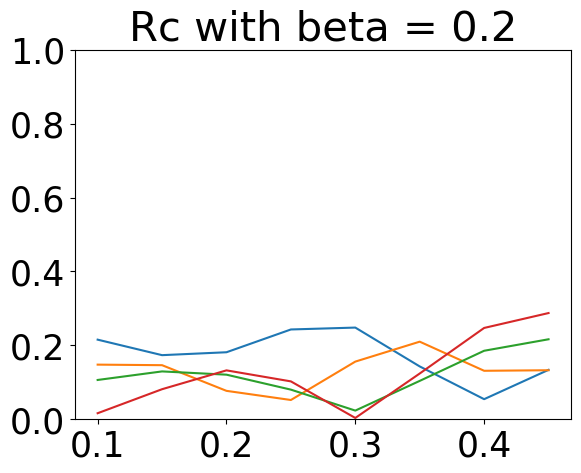

In [15]:
for c in range(N):
    plt.plot( t_hist,R[:,c])
plt.ylim(0,1)
plt.title( "Rc with beta = " +  str(beta))

# **Calculate $\Phi^R$**

$$
\Phi^R[ X ; \tau] = \phi^R[ X ; \tau , B^{MIB}]
$$

$$
\phi^R[ X ; \tau , B^{MIB}] = \phi[ X ; \tau , B] + min_{i,j} I(M^i_{t - \tau} ; M_t^j) 
\\ = I(X_t;X_{t - \tau}) - \Sigma_{j = 1}^{2} I(M^k_{t - \tau} ; M^k_t)  + min_{i,j} I(M^i_{t - \tau} ; M_t^j) 
$$



Calc $I(X_t;X_{t - \tau}) = H( X^t ) - H( X^t | X^{t - \tau} ) $

In [16]:
from scipy.stats import entropy

def prob_distribute(state, n):
    prob_dis = [0] * (2**n)
    for i in range(len(state)):
        prob_dis[state[i]] += 1 / len(state)
    return prob_dis

def make_whole_state(hist,n):
    stnumls = np.array( [0]*len(hist) )
    for i in range(len(hist)):
        stnum = 0
        for j in range(n):
            stnum += 2**j*hist[i][j]
        stnumls[i] = stnum    
    whole_state_pr = prob_distribute(stnumls,n)
    return stnumls , whole_state_pr

# H( Xt | Xt-t )
def calc_cond_ent( whole_state , whole_state_pr , Tau ):
    cond_entropy = 0
    for i in range( len(whole_state_pr) ):
        cond_state_dis = [0] * (len(whole_state_pr))
        for j in range( len(whole_state) - int(Tau/dt) ):
            if whole_state[j] == i :
                #seek state of Tau after
                cond_state_dis[ whole_state[ j + int(Tau/dt) ] ] += 1
        if sum(cond_state_dis) != 0 :
            cond_state_pr = np.array(cond_state_dis) / sum(cond_state_dis)
            cond_entropy += whole_state_pr[i] * entropy(cond_state_pr, base=2)
    return cond_entropy

# I ( X ) = H(X) - H( Xt | Xt-t )
def Calc_Mutual_info( X , Tau ):
    whole_state, whole_state_pr = make_whole_state( X, len(X[0]) )
    Mutual_info = entropy(whole_state_pr,base = 2) - calc_cond_ent(whole_state,whole_state_pr,Tau)
    return Mutual_info

**Calculate $\Sigma_{j = 1}^{2} I(M^k_{t - \tau} ; M^k_t)$**






In [17]:
def calc_cuted_Mutual_info(X,c,Tau):
    M1 = [ [] for i in range(len(X))]
    M2 = [ [] for i in range(len(X))]
    for i in range(len(X)):
        for j in range(len(X[0])):
            if c[j] : M1[i].append(X[i][j]) 
            else :   M2[i].append(X[i][j])
    M1 = np.array(M1) ; M2 = np.array(M2)
    return Calc_Mutual_info(M1,Tau) + Calc_Mutual_info(M2,Tau)

**Find $B^{MIB}$**

In [18]:
def KH(X,c):
    eps = 10**(-5)
    M1 = [ [] for i in range(len(X))]
    M2 = [ [] for i in range(len(X))]
    for i in range(len(X)):
        for j in range(len(X[0])):
            if c[j] : M1[i].append(X[i][j]) 
            else :   M2[i].append(X[i][j])
    M1 = np.array(M1) ; M2 = np.array(M2)
    _ , M1_whole_st_pr = make_whole_state(M1,len(M1[0]))
    _ , M2_whole_st_pr = make_whole_state(M2,len(M2[0]))
    return max(eps , min ( entropy(M1_whole_st_pr,base = 2) , entropy(M2_whole_st_pr,base = 2) )  )

def find_MIB(X,Tau):
    CUTS = []
    for i in range(2 ** N):
        op = [1] * N
        for j in range(N):
            if ((i >> j) & 1):
                op[N - 1 - j] = 0
        if 1<= op.count(1) and op.count(1) <= 4 : CUTS.append(op)
    
    MIB = []
    min_Mutual = 10**10
    for cut in CUTS:
        tmpM = calc_cuted_Mutual_info(X,cut,Tau) / KH(X,cut)
        if tmpM < min_Mutual :
            min_Mutual = tmpM
            MIB = copy.copy(cut)
    print(MIB)
    return MIB

$
\phi[ X ; \tau , B^{MIB}] = I(X_t;X_{t - \tau}) - \Sigma_{k = 1}^{2} I({M^{MIB}}^k_{t - \tau} ; {M^{MIB}}^k_t)
$

In [19]:
def Calc_phi(X,Tau):
    res = Calc_Mutual_info(X,Tau) - calc_cuted_Mutual_info(X,find_MIB(X,Tau),Tau)
    print(res)
    return res

In [20]:
# Hyper Prameters
Tau = 3
gamma = 0.8

# time steps 
dt = 0.05 #0.05
time_step = 10**3 #5 * 10**6
t_max = (time_step - 1) * dt

betas = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.23,0.26,0.29,0.32,0.35,0.40,0.45,0.46]
phi_hist = [] ; Xi_hist = [] ; lamb_hist = []
for beta in betas :
    print("calculating with beta = " + str(beta))
    #dtheta_hist,theta_hist,t_hist = Euler(theta,dtheta,pi/2 - beta)
    dtheta_hist,theta_hist,t_hist = RungeKutta(pi/2 - beta)
    R = calc_R(theta_hist)
    X = calc_X(R)
    #phi_hist.append( Calc_phi(X,Tau) )

    #metastability 
    Xi = calc_Xi(R) ; lamb = calc_lambda(R)
    Xi_hist.append( Xi ) ; lamb_hist.append( lamb )

calculating with beta = 0.01
calculating with beta = 0.02
calculating with beta = 0.03
calculating with beta = 0.04
calculating with beta = 0.05
calculating with beta = 0.06
calculating with beta = 0.07
calculating with beta = 0.08
calculating with beta = 0.09
calculating with beta = 0.1
calculating with beta = 0.11
calculating with beta = 0.12
calculating with beta = 0.13
calculating with beta = 0.14
calculating with beta = 0.15
calculating with beta = 0.16
calculating with beta = 0.17
calculating with beta = 0.18
calculating with beta = 0.19
calculating with beta = 0.2
calculating with beta = 0.23
calculating with beta = 0.26
calculating with beta = 0.29
calculating with beta = 0.32
calculating with beta = 0.35
calculating with beta = 0.4
calculating with beta = 0.45
calculating with beta = 0.46


**history storage**
```
#teian_diff
phi_hist = [0.0,0.0,1.1509563188225913,2.21113837232129,3.8185938648803495,4.79425605703074,5.517707019217745,5.602437466043008,5.106971879918529,4.208596564319368,3.033445080142819,1.8685997950517712,1.1669132946266516,0.7865305633275637,0.4349689402422974,0.19451106112529004,0.066061899845455410,-0.019624615064562034,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
#teian
phi_hist = [0.0,0.049689402422974,0.2685997950517712,0.623345089191119,1.806971879942819,3.1509563188225913,4.11113837232129,4.2185938648803495,3.99425605703074,3.517707019217745,2.602437466043008,1.806971879918529,1.208596564319368,0.533445080142819,0.2669132946266516,0.1865305633275637,0.09451106112529004,0.066061899845455410,-0.019624615064562034,0.0,0.0,0.0,0.0,0.0,0.0]
```



In [21]:
#for the record
print("betas = ") ; print(betas)
print("phi_hist = ") ; print(phi_hist)
print("Xi_hist = ") ; print(Xi_hist)  
print("lamb_hist = ") ; print(lamb_hist)

betas = 
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.4, 0.45, 0.46]
phi_hist = 
[]
Xi_hist = 
[0.09445790350106094, 0.09471877835700562, 0.102523704376468, 0.6146713486972099, 0.643198421479329, 0.7000058161362548, 0.7069734897597811, 0.7166723874894264, 0.740569421009379, 0.7453283698304749, 0.7646054353186915, 0.7825364650237733, 0.7867310938177572, 0.8019389872289365, 0.8101368504819201, 0.8184649219311586, 0.8236840761047123, 0.8315518021969924, 0.8380453501880285, 0.8369836019325778, 0.858696715160149, 0.8713048896623209, 0.8820873737374313, 0.900986058837972, 0.9118466533536005, 0.932611750866251, 0.9506483250480307, 0.9543932317673703]
lamb_hist = 
[0.0022543468277193405, 0.002545624855874047, 0.0025276365510582587, 0.036532614508747056, 0.032206016253385206, 0.010637661368164185, 0.01411723751928761, 0.016652345906550323, 0.01111374164099111, 0.015064892861991957, 0.010475

In [22]:
#plot
"""
plt.figure(figsize=[15,12])
plt.rcParams["font.size"] = 25

plt.scatter(betas,phi_hist,s=200)
#plt.scatter(betas,H_hist)
plt.xlim(0, 0.5)
plt.ylim(-0.2, 6)
plt.title(  "relation of "+ r"$\beta$" + " and "+ r"$\Phi$")
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\Phi[ X ; \tau ]$')
"""

'\nplt.figure(figsize=[15,12])\nplt.rcParams["font.size"] = 25\n\nplt.scatter(betas,phi_hist,s=200)\n#plt.scatter(betas,H_hist)\nplt.xlim(0, 0.5)\nplt.ylim(-0.2, 6)\nplt.title(  "relation of "+ r"$\x08eta$" + " and "+ r"$\\Phi$")\nplt.xlabel(r\'$\x08eta$\')\nplt.ylabel(r\'$\\Phi[ X ; \tau ]$\')\n'

Text(0, 0.5, '$\\lambda$')

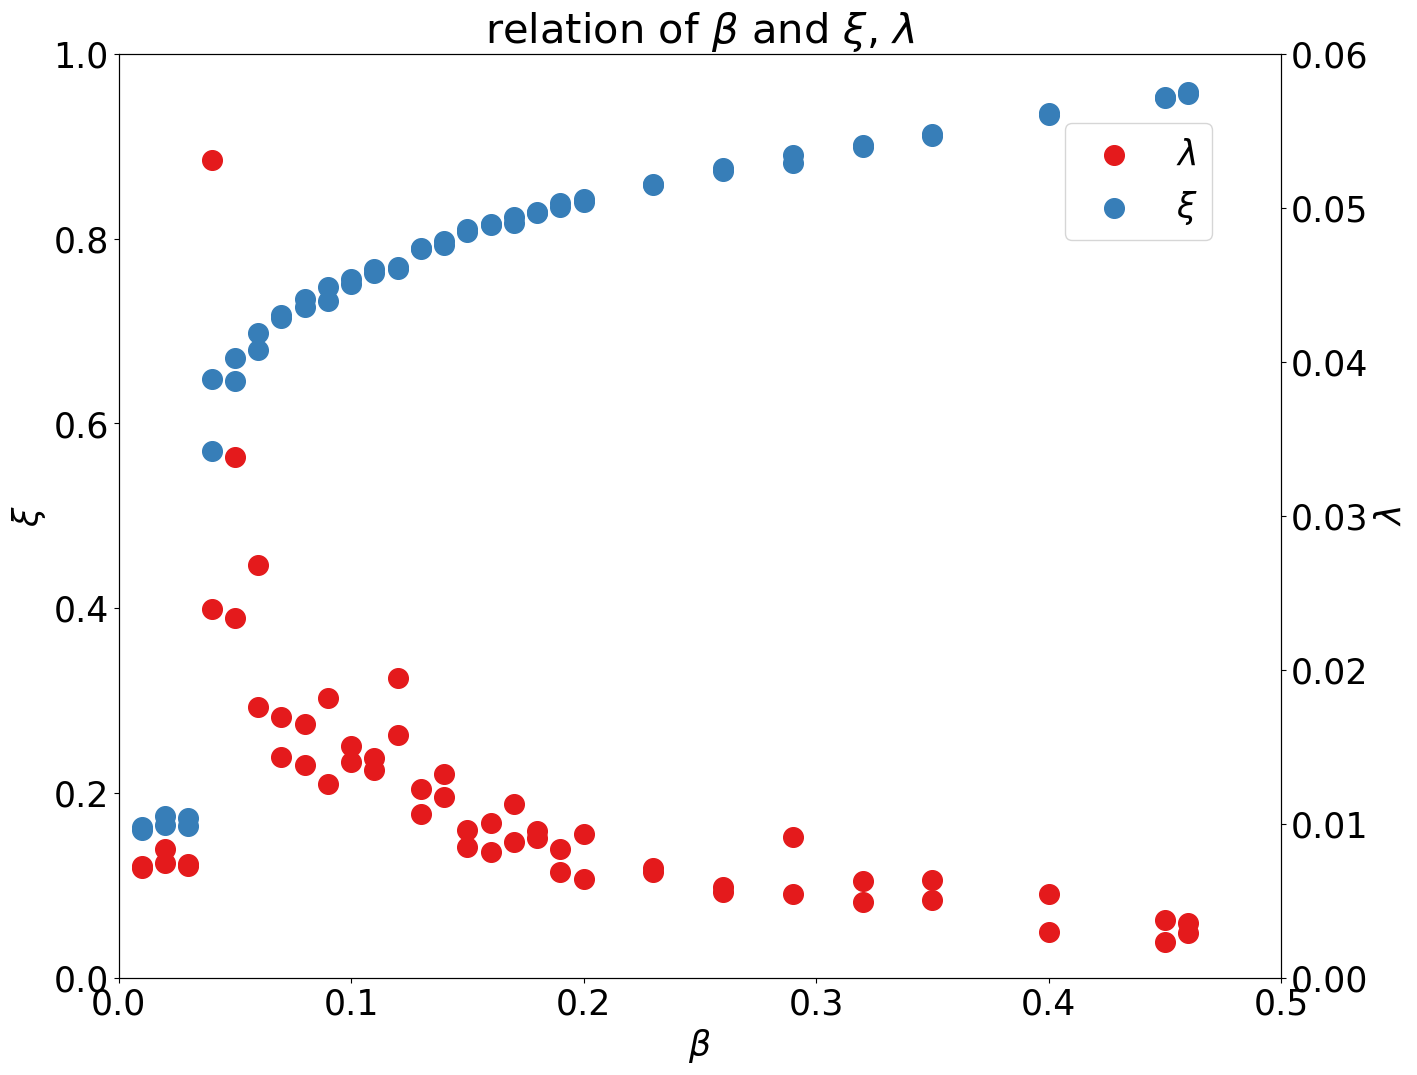

In [23]:
 #metastability 
#plot

beta_new = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.4, 0.45, 0.46]
Xi_new = [0.16351396666492332, 0.17546243548862936, 0.17296723294279157, 0.5704814179900648, 0.6705081898292389, 0.697426904050565, 0.7168937635057236, 0.726365922660832, 0.7324154174977916, 0.7508747310026488, 0.7629542386621828, 0.7695854440345042, 0.7886455733227428, 0.7932397481030627, 0.8099229897791413, 0.8142156319688472, 0.8228786120931084, 0.8286745304428225, 0.8388147605068912, 0.839740130937948, 0.8577938817916309, 0.8759503647413048, 0.8901709544581933, 0.9013797320684787, 0.9130405249107111, 0.9334332485100273, 0.9535644704621645, 0.9584169315932809]
lamb_new = [0.007251225348534416, 0.008345969261091171, 0.0072349603376839775, 0.05306977341555806, 0.023371543276995477, 0.017548298530186284, 0.01430959496717073, 0.01649149622412799, 0.018189931532391457, 0.015031652033055513, 0.01427393895284354, 0.01575767310933006, 0.010643075467754936, 0.013235714720802028, 0.00846671848798698, 0.01007037061163448, 0.008795399405940063, 0.00953799691683252, 0.006867631340409403, 0.009332464905887536, 0.006857978320522071, 0.005540301958226209, 0.005435073405167025, 0.004916985446956609, 0.005032241401355684, 0.00546776187188332, 0.0023513935925311993, 0.0029047433049993253]

beta_new += [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.4, 0.45, 0.46]
Xi_new += [0.15939687288020296, 0.16560786487937712, 0.16370444178384758, 0.6482959080159522, 0.6453476365891421, 0.6798144369162324, 0.7142280707926596, 0.7342649111449644, 0.7473909388000438, 0.7562103297258568, 0.7667700512757439, 0.7666572711640269, 0.7893893049496264, 0.7969592424365393, 0.8070541934524603, 0.8152463909946975, 0.817285261866989, 0.8275292535827586, 0.8345352058514197, 0.842898018951473, 0.859058204505842, 0.8730800192832076, 0.8815493960377853, 0.8985749017458764, 0.91138372545671, 0.9361135616982292, 0.9524892664669895, 0.9561167796394807]
lamb_new += [0.007136889861174311, 0.007457587436480083, 0.007388598397669198, 0.0239186504212712, 0.03382883169530572, 0.026817781331788183, 0.016904626220592935, 0.013796481208297852, 0.01259137742196326, 0.013995825190082661, 0.013457344727074721, 0.01946333299077382, 0.01225539196150321, 0.011740176182854981, 0.009567533999008407, 0.008136023196942673, 0.011281513813100524, 0.009064893390073187, 0.008350420360124079, 0.006426196922099012, 0.0071228437312710145, 0.005915444400043987, 0.009114159852980088, 0.006310187821942189, 0.006346785786548553, 0.002957354363425504, 0.003730479913504703, 0.003548163626774556]

fig, ax1 = plt.subplots(figsize=[15,12])
ax2 = ax1.twinx()
# 2軸グラフの本体設定
ax1.scatter(beta_new,Xi_new,s=200,color=cm.Set1.colors[1], label=r"$\xi$")
ax2.scatter(beta_new,lamb_new,s=200,color=cm.Set1.colors[0], label=r"$\lambda$")
#グラフタイトルを付ける
plt.title("relation of "+ r"$\beta$" + " and "+ r"$\xi$" + ", "+ r"$\lambda$" , fontsize=30)
# 凡例の表示のため、handler1と2にはグラフオブジェクトのリスト情報が入る
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler2 + handler1, label2 + label1, loc=1, borderaxespad=2)
ax1.set_xlim(0, 0.5)
ax1.set_ylim([0, 1.0])
ax2.set_ylim([0, 0.06])
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel(r"$\xi$")
ax2.set_ylabel(r"$\lambda$")

Text(0, 0.5, '$\\lambda$')

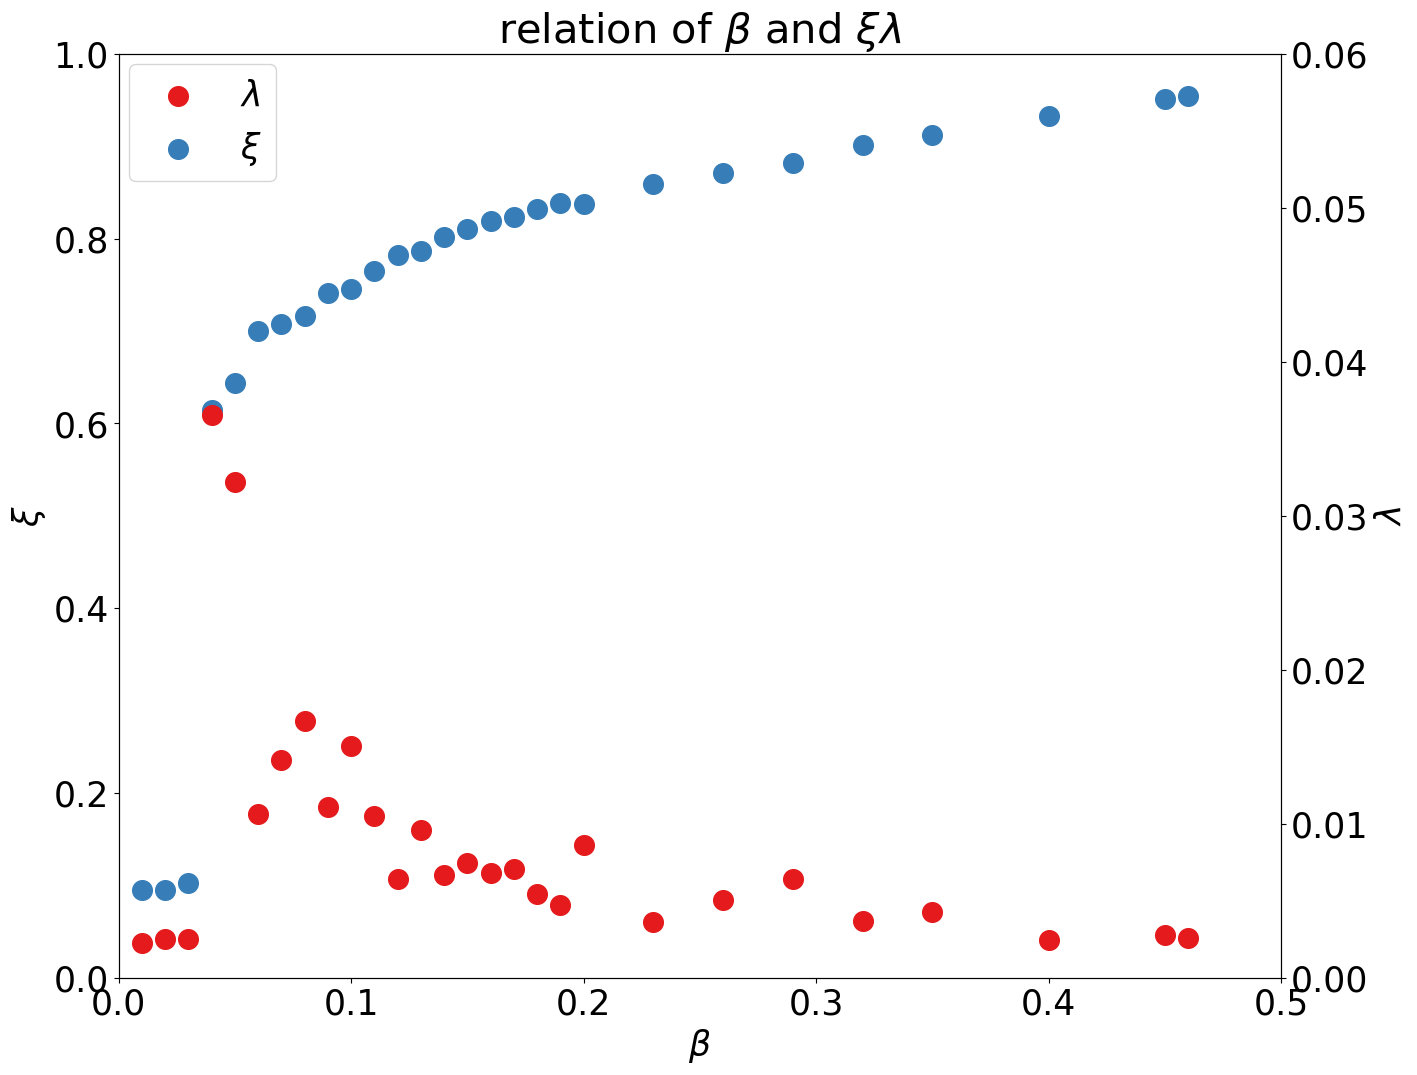

In [24]:
 #metastability 
#plot
fig, ax1 = plt.subplots(figsize=[15,12])
ax2 = ax1.twinx()
# 2軸グラフの本体設定
ax1.scatter(betas,Xi_hist,s=200,color=cm.Set1.colors[1], label=r"$\xi$")
ax2.scatter(betas,lamb_hist,s=200,color=cm.Set1.colors[0], label=r"$\lambda$")
#グラフタイトルを付ける
plt.title("relation of "+ r"$\beta$" + " and "+ r"$\xi$" + r"$\lambda$" , fontsize=30)
# 凡例の表示のため、handler1と2にはグラフオブジェクトのリスト情報が入る
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler2 + handler1, label2 + label1, loc=2, borderaxespad=0.3)
ax1.set_xlim(0, 0.5)
ax1.set_ylim([0, 1.0])
ax2.set_ylim([0, 0.06])
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel(r"$\xi$")
ax2.set_ylabel(r"$\lambda$")

(array([0.00392157, 0.00490196, 0.00392157, 0.00392157, 0.00490196,
        0.        , 0.00196078, 0.00392157, 0.00588235, 0.00490196,
        0.00490196, 0.00294118, 0.00490196, 0.00882353, 0.00392157,
        0.00098039, 0.00588235, 0.00686275, 0.00588235, 0.00588235,
        0.00490196, 0.00294118, 0.00490196, 0.00196078, 0.00196078,
        0.00490196, 0.00686275, 0.00294118, 0.00196078, 0.00686275,
        0.00882353, 0.        , 0.00686275, 0.00392157, 0.00392157,
        0.00588235, 0.00196078, 0.00588235, 0.00294118, 0.00392157,
        0.00294118, 0.00098039, 0.00098039, 0.00196078, 0.00490196,
        0.00098039, 0.00098039, 0.00098039, 0.00294118, 0.00490196]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 193.8, 198.9

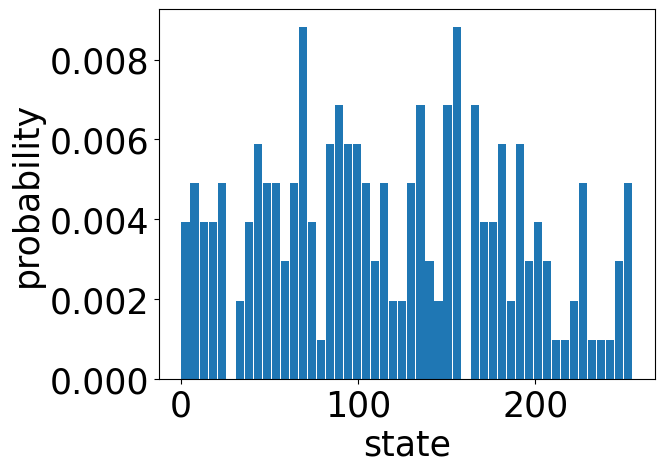

In [25]:
import matplotlib.pyplot as plt
import random

list = [ random.randint(0,255) for _ in range(200)]
plt.xlabel("state")
plt.ylabel("probability")
plt.hist(list,density=True, rwidth=0.9,bins=50)

(array([1.40001, 0.59999]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

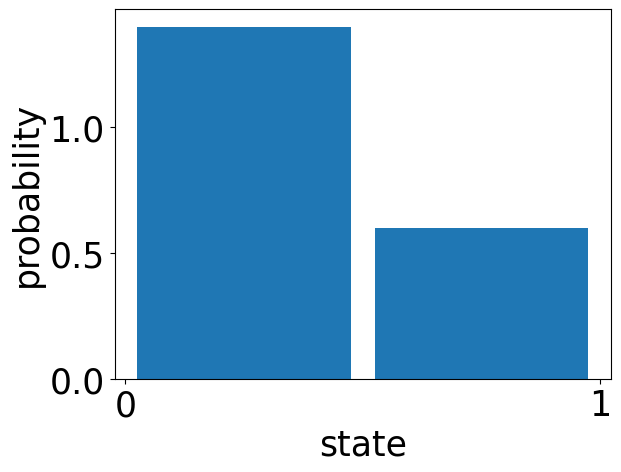

In [26]:
import matplotlib.pyplot as plt
import random
import numpy as np

list = [ 1 if random.random() > 0.7 else 0 for _ in range(200000) ]
plt.xlabel("state")
plt.ylabel("probability")
plt.xticks([0, 1])
plt.hist(list,density=True, rwidth=0.9,bins=2)

In [27]:
import numpy as np
l = np.arange(0,100,10)
print(l)

[ 0 10 20 30 40 50 60 70 80 90]
